# Importe as bibliotecas

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import trange
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from google.colab import files
import matplotlib.pyplot as plt
from matplotlib.image import imread
# ...

Baixar o dataset

**ALTERAR PARA 244 CASO FOR TESTAR A ALEXNET**

In [ ]:
# Para LeNet e CNN personalizada
transform_32 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Para AlexNet
transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Baixar o dataset
# Se o download falhar, tente novamente

# train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True, transform=transform_224)
# test_dataset = datasets.MNIST(root="./datasets", train=False, download=True, transform=transform_224)
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True, transform=transform_32)
test_dataset = datasets.MNIST(root="./datasets", train=False, download=True, transform=transform_32)

Separando dataset de treino, teste e validação

In [ ]:
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(54000, 6000, 10000)

Visualizar o dataset

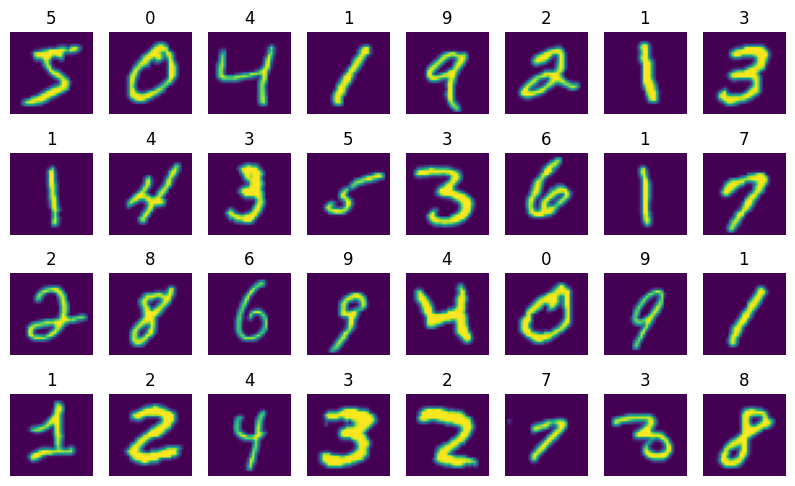

In [ ]:
ROWS, COLS = 4, 8

fig, axs = plt.subplots(ROWS, COLS, figsize=(10, 6))
for i, ax in enumerate(axs.flatten()):
    img, label = train_val_dataset[i]
    ax.imshow(img.numpy()[0])
    ax.set_title(label)
    ax.axis('off')

# Construa uma arquitetura de rede convolucional
Construa uma rede neural convolucional (CNN).

##CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

##LeNet

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(576, 120)  # Ajuste conforme o número de entradas da camada linear
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        # Após a segunda camada de pooling, o tamanho de x deve ser ajustado para a camada linear
        x = x.view(-1, 576)  # Ajuste para corresponder ao tamanho correto
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


##AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Defina os parâmetros da rede, e.g. número de épocas e *learning rate*.

In [ ]:
BATCH_SIZE = 16
INIT_LR = 1e-3
EPOCHS = 10

# Inicialize os *dataloaders*
Os dataloaders carregarão lotes de imagens para o treinamento do modelo

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Inicialize o modelo
Configure o otimizador, a função de perda e inicialize o modelo

In [ ]:
#CNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=INIT_LR)

In [ ]:
#LeNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=INIT_LR)

In [ ]:
#AlexNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=INIT_LR)

# Treinamento
Treine a sua arquitetura no conjunto de treino.

Arquitetura adaptada para o CNN

In [ ]:
loss_train = np.zeros((EPOCHS,))
loss_val = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))
min_loss = 100000
best_epoch = -1

# Loop de treinamento
for epoch in trange(EPOCHS):

    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)

        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)


    loss_train[epoch] = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)

            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()

    # Calcular a média da perda de validação e acurácia
    loss_val[epoch] = val_loss / len(val_loader.dataset)
    accuracy_list[epoch] = correct / len(val_loader.dataset)

    # Verificar se o modelo atual é o melhor baseado na perda de validação mínima
    if loss_val[epoch] < min_loss:
        best_epoch = epoch
        min_loss = loss_val[epoch]

print('\nMenor erro da Validação:', min_loss, ' na época', best_epoch)

100%|██████████| 10/10 [04:06<00:00, 24.67s/it]


Menor erro da Validação: 0.03752382453267334  na época 3


Arquitetura de treino padrão para (AlexNet e LeNet)

In [ ]:
min_loss = 100000
best_epoch = -1

loss_train = np.zeros((EPOCHS,))
loss_val = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in trange(EPOCHS):
    model.train()
    train_loss = 0.0

    # Loop sobre os mini-batches de treinamento
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train[epoch] = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

            correct += (torch.argmax(y_pred, dim=1) == y_batch).sum().item()

    loss_val[epoch] = val_loss / len(val_loader)
    accuracy_list[epoch] = correct / len(val_loader.dataset)

    if loss_val[epoch] < min_loss:
        best_epoch = epoch
        min_loss = loss_val[epoch]

print('\nMenor erro da Validação: ', min_loss, ' EPOCA ', best_epoch)

100%|██████████| 10/10 [04:32<00:00, 27.23s/it]


Menor erro da Validação:  0.04402759052086791  EPOCA  5


# Resultados
Teste a sua arquitetura no conjunto de teste, descreva e visualize os resultados.

##CNN

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0396, Test Accuracy: 0.99%


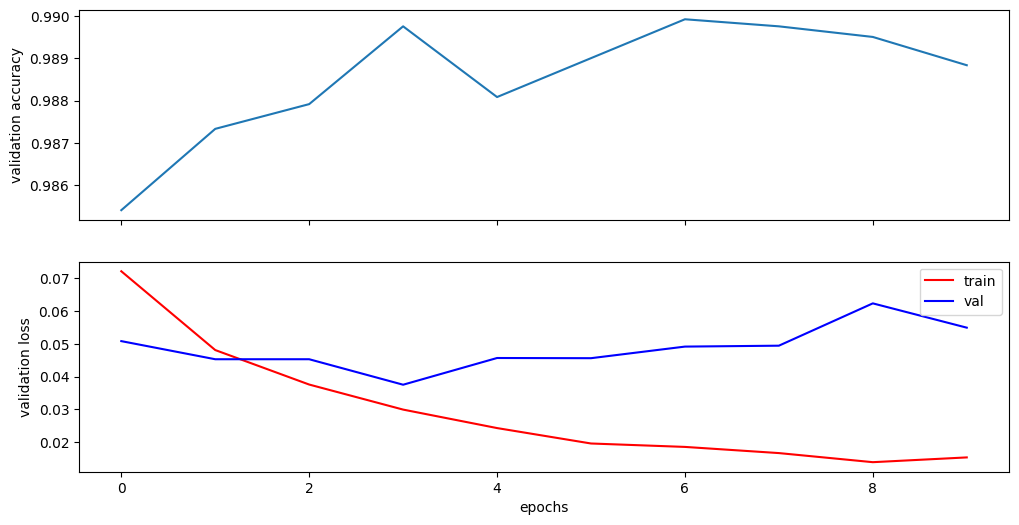

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_train,'-r',label='train')
ax2.plot(loss_val,'-b',label='val')
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");
ax2.legend()

In [ ]:
# Caminho onde o modelo será salvo
model_path = 'best_model_cnn.pth'

# Salvando o modelo e o otimizador
torch.save({
    'epoch': best_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': min_loss,
}, model_path)

# Baixar o arquivo
files.download(model_path)

print(f"Modelo salvo na época {best_epoch} com perda de validação {min_loss}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelo salvo na época 3 com perda de validação 0.03752382453267334


##LeNet

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0470, Test Accuracy: 0.99%


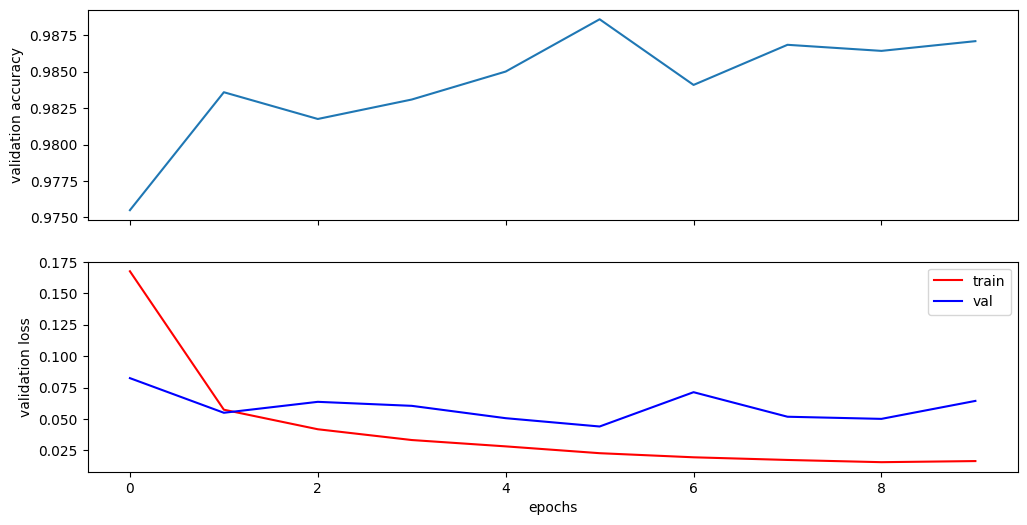

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_train,'-r',label='train')
ax2.plot(loss_val,'-b',label='val')
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");
ax2.legend()

In [ ]:
# Caminho onde o modelo será salvo
model_path = 'best_model_lenet.pth'

# Salvando o modelo e o otimizador
torch.save({
    'epoch': best_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': min_loss,
}, model_path)

# Baixar o arquivo
files.download(model_path)

print(f"Modelo salvo na época {best_epoch} com perda de validação {min_loss}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelo salvo na época 5 com perda de validação 0.04402759052086791


##AlexNet

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0412, Test Accuracy: 0.99%


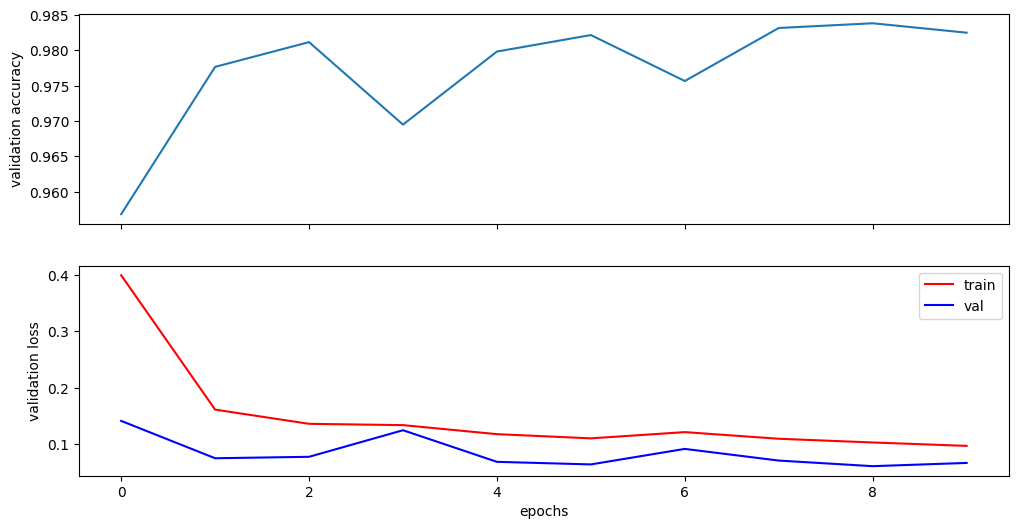

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_train,'-r',label='train')
ax2.plot(loss_val,'-b',label='val')
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");
ax2.legend()

In [ ]:
# Caminho onde o modelo será salvo
model_path = 'best_model_alexnet.pth'

# Salvando o modelo e o otimizador
torch.save({
    'epoch': best_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': min_loss,
}, model_path)

# Baixar o arquivo
files.download(model_path)

print(f"Modelo salvo na época {best_epoch} com perda de validação {min_loss}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelo salvo na época 8 com perda de validação 0.060699631770451866


# Conclusões


Para fazer uma comparação de qual o melhor modelo para
esse problema de classificação, eu tentei manter os parâmetros iguais para eles e ver como eles iriam se adaptar. Com um LR bem baixo e mesmo sem um grande número de épocas, o problema foi resolvido.  

Eu defini os parâmetros tendo uma noção do que o seguinte artigo fala: https://arxiv.org/abs/2103.03995

Manter o LR conservador garante que, se estiver no caminho certo, você conseguirá ter bons resultados.

No que quis respeito ao batch_size, mantive 16 por standard, mas a literatura cita bons resultados com 64. Tanto que há possibilidade de ter resultados mais promissores.

Quanto às épocas, não vi necessidade de mais que 10 pois não havia sinal de melhora significativa, apenas algumas poucas variações, então seria mais do mesmo. Por o dataset ser grande, a rede teve muitos casos para ver onde acertou e onde errou.

Nota: mesmo a AlexNet sendo a mais demorada para treinar e talvez a mais robusta (com certeza a mais pesada), não foi ela quem teve os melhores resultados.

Plus: eu acabei tendo dificuldades em implementar apenas uma arquitetura de treino, a alexnet e lenet sim usam a mesma, porém a cnn usa uma própria.

##Casos que ele pode errar:

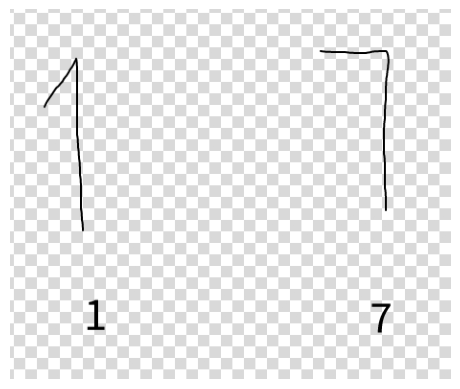

In [ ]:
img = imread('/content/Screenshot from 2024-06-14 21-00-08.png')
plt.imshow(img)
plt.axis('off')
plt.show()


##Considerações Finais

Mesmo que os resultados do treinamento foram bons, acredito que há como melhorar. Talvez seguir o que há de mais recente na literatura seja um melhor caminho.
Mas para esse problema, esses modelos se saíram bem.
